In [1]:
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from tqdm.notebook import tqdm # Waiting/loading bar for loops

import multiprocess

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from stochastic_gradient_descent import * 
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [52]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/01_regression_resampling/img/"

In [5]:
# Data generation
N = 2048
p = 4
sigma = 0.1
x,y,z = random_x_y_franke(N, sigma=sigma)
X = generate_design_matrix(x, y, p)

In [6]:
def relative_error_own_sk(sk_pipeline, sgd_pipeline):
    return np.linalg.norm(sk_pipeline.steps[-1][1].coef_ - sgd_pipeline.steps[-1].betas)/np.linalg.norm(sk_pipeline.steps[-1][1].coef_)
def relative_error_sk(analytical_pipeline, sgd_sk_pipeline):
    return np.linalg.norm(analytical_pipeline.steps[-1].betas - sgd_sk_pipeline.steps[-1][1].coef_)/np.linalg.norm(analytical_pipeline.steps[-1].betas)
def relative_error_own(analytical_pipeline, sgd_pipeline):
    return np.linalg.norm(analytical_pipeline.steps[-1].betas - sgd_pipeline.steps[-1].betas)/np.linalg.norm(analytical_pipeline.steps[-1].betas)

## Ordinary Least Squares

In [7]:
# Compute "Ground Truth"
ols_pinv = Pipeline([Standardization(), 
                     OrdinaryLeastSquare(solver="pinv")])
ols_pinv.fit(X,z)

### Learning Rate Dependency 

In [12]:
minibatches = N
max_epochs = 1000
tol=None
seed=42

M = 20
lrs_sk = np.logspace(-5,np.log10(0.04),M)

def compute_error(lr):
    # Pipeline using our SGD implmentation
    # Note: The factor of 1/2 in the learning rate to compensate for sklearn's overfall factor of 1/2 in the
    #       squared error cost function entering SGDRegressor. See:
    #       https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd), ols_sgd

pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, lrs_sk), total=M)
error_to_analytical, trained_sgds = list(map(list, zip(*list(result))))

sk_error_to_analytical, trained_sks = np.empty(M), []

for i, lr in enumerate(tqdm(lrs_sk)):    
    # Pipeline using sklearn implementations
    ols_sk =make_pipeline(StandardScaler(), SGDRegressor(penalty=None, 
                                                     learning_rate="constant",
                                                     eta0=2*lr,
                                                     max_iter=max_epochs,
                                                     shuffle=True,
                                                     random_state=seed,
                                                     tol=tol))
    
    ols_sk.fit(X,z)
    sk_error_to_analytical[i] = relative_error_sk(ols_pinv, ols_sk)
    trained_sks.append(ols_sk)
    
error_own_sk = [relative_error_own_sk(trained_sks[i], trained_sgds[i]) for i in range(M)]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

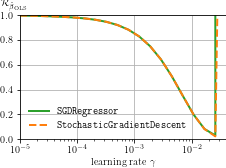

In [97]:
size = (3.7, 0.618 * 3.7) if save else (10,6)
fig,ax = plt.subplots(figsize=size)
error_label = r"$\mathcal{R}_{\hat{\beta}_\mathrm{OLS}}$"

ax.set_xscale("log")
ax.set_xlabel(r"learning rate  $\gamma$")
ax.set_ylabel(error_label, rotation=0)
ax.yaxis.set_label_coords(-0.03,1.03)

ax.plot(lrs_sk, sk_error_to_analytical, label=r"\texttt{SGDRegressor}", c="C2")
ax.plot(lrs_sk, error_to_analytical, label=r"\texttt{StochasticGradientDescent}", c="C1", ls="dashed")

ax.legend(*ax.get_legend_handles_labels())
ax.set_xlim([1e-5,0.04])
ax.set_ylim([0,1])

ax.grid(True)

if save:
    fig.savefig(save_dir + "sgd_ols_learning_rate.pdf", bbox_inches="tight")
else:
    plt.show()

### Dependence on the Number of Mini Batches

In [66]:
minibatches = np.power(2,np.arange(12))
max_epochs = 1000
tol=None
seed=42
lr = 0.02

def compute_error(batches):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epochs,
                                             batches=batches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

M = minibatches.shape[0]
pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, minibatches), total=M)
error_to_analytical_minibatches = list(result)

  0%|          | 0/12 [00:00<?, ?it/s]

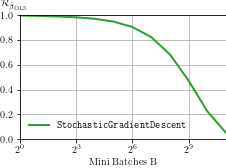

In [98]:
size = (3.7, 0.618 * 3.7) if save else (10,6)
fig,ax = plt.subplots(figsize=size)
ax.set_xscale('log', base=2)
ax.set_xlabel(r"Mini Batches B")
ax.set_ylabel(error_label, rotation=0)
ax.yaxis.set_label_coords(-0.03,1.03)
ax.plot(minibatches, error_to_analytical_minibatches, label=r"\texttt{StochasticGradientDescent}", c="C2")
ax.legend(*ax.get_legend_handles_labels())
ax.set_ylim([0,1])
ax.grid(True)

if save:
    fig.savefig(save_dir + "sgd_ols_minibatches.pdf", bbox_inches="tight")
else:
    plt.show()

### Dependence on the Number of Epochs

In [17]:
minibatches = 2**8
max_epochs = np.arange(100,12000+100,100)
tol=None
seed=42
lr = 0.02

def compute_error(max_epoch):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epoch,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

M = max_epochs.shape[0]
pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, max_epochs), total=M)
error_to_analytical_epochs = list(result)

  0%|          | 0/120 [00:00<?, ?it/s]

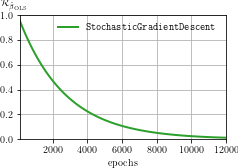

In [99]:
size = (3.7, 0.618 * 3.7) if save else (10,6)
fig,ax = plt.subplots(figsize=size)
max_epochs = np.arange(100,12000+100,100)
ax.set_xlabel(r"epochs")
ax.set_ylabel(error_label, rotation=0)
ax.yaxis.set_label_coords(-0.03,1.03)
ax.plot(max_epochs, error_to_analytical_epochs, label=r"\texttt{StochasticGradientDescent}", c="C2")
ax.legend(*ax.get_legend_handles_labels())
ax.set_ylim([0,1])
if save:
    fig.savefig(save_dir + "sgd_ols_epochs.pdf")
else:
    plt.show()

### Adaptive Learning Rate Schedule

In [19]:
eta0 = 0.02
schedules = [Constant(log=True, eta0=eta0), 
             InverseScaling(log=True, eta0=eta0), 
             AdaGrad(log=True, eta0=eta0), 
             RMSProp(log=True, eta0=eta0)]

minibatches = N//4
max_epochs = 2000
tol=None
seed=42

M = len(schedules)
error_to_analytical_schedules = np.empty(M)
for i,schedule in enumerate(tqdm(schedules)):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=schedule,
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    error_to_analytical_schedules[i] = relative_error_own(ols_pinv, ols_sgd)

  0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
#Adagrad and RMSProp yield feature-specific learning rates.
#Only show the mean of all

print(schedules[2].learning_rates[0].shape)
schedules[2].learning_rates = np.mean(schedules[2].learning_rates, axis=1)
schedules[3].learning_rates = np.mean(schedules[3].learning_rates, axis=1)

(14,)


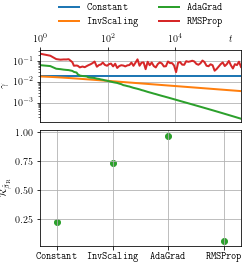

In [151]:
labels = [r"\texttt{Constant}",r"\texttt{InvScaling}",r"\texttt{AdaGrad}",r"\texttt{RMSProp}"]

kwargs = {"height_ratios":[0.618,1]}
size = (3.6, 3.6) if save else (10,6)
fig, ax = plt.subplots(nrows=2, figsize=size, gridspec_kw=kwargs)
plt.subplots_adjust(hspace=0.09)

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top') 
ax[0].set_ylabel(r"$\gamma$")
ax[0].set_xlabel(r"$t$")
ax[0].xaxis.set_label_coords(.95,1.12)

for label,schedule in zip(labels,schedules):
    lr = np.array(schedule.learning_rates)
    log_idx = np.unique(np.geomspace(1, len(lr), 
                                     num=100, 
                                     endpoint=False).astype(int))
    ax[0].plot(log_idx,lr[log_idx],label=label)
    
ax[1].set_ylabel(error_label)
ax[1].scatter(labels,error_to_analytical_schedules, c="C2")

for a in ax:
    a.legend(*a.get_legend_handles_labels(), 
             ncol=2, 
             bbox_to_anchor=[0.05,1.2],
             loc="lower left")
ax[1].margins(x=0.1) 
if save:
    fig.savefig(save_dir + "sgd_ols_schedule.pdf", bbox_inches="tight")
else:
    plt.show()

## Ridge Regression

In [22]:
from functools import partial

minibatches = N
max_epochs = 1000
tol=None
seed=42
M = 20
lrs = np.logspace(-5,np.log10(0.04),M)
penalties=np.hstack((np.logspace(-7,-2,6), np.logspace(-1,2,10)))

def compute_error(lr, penalty):
    # Pipeline using our SGD implmentation
    # Note: 
    #  (i)  The factor of 1/2 in the learning rate to compensate for sklearn's overfall factor of 1/2 in the
    #       squared error cost function *and* the L2 penalty entering SGDRegressor. See:
    #       https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation
    #  (ii) The factor 1/N for the penalties
    ridge_sgd = Pipeline([Standardization(), 
                          RidgeRegression(solver="sgd", 
                                            penalty=penalty/N,
                                            learning_rate=lambda t, grad: lr,
                                            max_epochs=max_epochs,
                                            batches=minibatches,
                                            seed=seed,
                                            tol=tol)])
    ridge_inv = Pipeline([Standardization(), 
                     RidgeRegression(penalty=penalty, solver="inv")])
    
    ridge_inv.fit(X,z)
    ridge_sgd.fit(X,z)
    
    return relative_error_own(ridge_inv, ridge_sgd)

pool = multiprocess.Pool()

error_ridge_to_analytical = np.empty((penalties.shape[0],lrs.shape[0]))

for j, penalty in enumerate(tqdm(penalties)):
    result = pool.map(partial(compute_error, penalty=penalty), lrs)
    error_ridge_to_analytical[j,:] =  list(result)

sk_error_ridge_to_analytical = np.empty((penalties.shape[0],lrs.shape[0]))

for j, penalty in enumerate(tqdm(penalties)):
    for i, lr in enumerate(lrs): 
        ridge_sk =make_pipeline(StandardScaler(), SGDRegressor(penalty="l2", 
                                                             alpha=penalty/N,
                                                             learning_rate="constant",
                                                             eta0=2*lr,
                                                             max_iter=max_epochs,
                                                             shuffle=True,
                                                             random_state=seed,
                                                             tol=tol))
        ridge_inv = Pipeline([Standardization(), 
                     RidgeRegression(penalty=penalty, solver="inv")])
    
        ridge_inv.fit(X,z)
        ridge_sk.fit(X,z)
        sk_error_ridge_to_analytical[j,i] = relative_error_sk(ridge_inv, ridge_sk)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

100.0


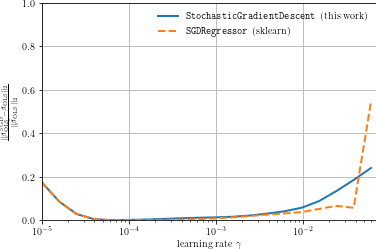

In [66]:
fig, ax = plt.subplots()
i=-1
print(penalties[i])
ax.set_xscale("log")
ax.set_xlabel(r"learning rate  $\gamma$")
ax.set_ylabel(r"$\frac{||\hat{\beta}^\mathrm{SGD}_\mathrm{OLS} - \hat{\beta}_\mathrm{OLS}||_2}{||\hat{\beta}_\mathrm{OLS}||_2}$")
ax.plot(lrs, error_ridge_to_analytical[i,:], label=r"\texttt{StochasticGradientDescent} (this work)")
ax.plot(lrs, sk_error_ridge_to_analytical[i,:], ls="dashed", label=r"\texttt{SGDRegressor} (sklearn)")
ax.legend(*ax.get_legend_handles_labels())
ax.set_xlim([1e-5,0.07])
ax.set_ylim([0,1])
plt.show()

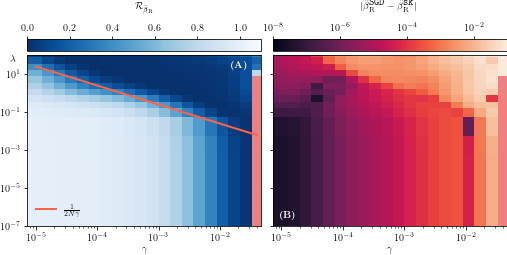

In [161]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

error_label = r"$\mathcal{R}_{\hat{\beta}_\mathrm{R}}$"
cmap = sns.color_palette("Blues_r", as_cmap=True).copy()
cmap.set_bad("lightcoral")
kwargs = { 
          "cmap":cmap,
          "shading":"nearest",
          "vmin":0,
          "vmax":1.1,
          "edgecolor": "face",
          "rasterized":True,
          "linewidth": 0
         }

fig, ax = plt.subplots(figsize=(8.6,8.6*0.4), ncols=2, sharey=True)
for a in ax:
    a.grid(False)
    a.set_yscale("log")
    a.set_xscale("log")
    a.set_xlabel(r'$\gamma$')
    a.set_ylim([penalties[0],penalties[-1]])

masked_error_ridge_to_analytical = error_ridge_to_analytical
masked_error_ridge_to_analytical[error_ridge_to_analytical>1] = np.nan

im = ax[0].pcolormesh(lrs, penalties, masked_error_ridge_to_analytical, **kwargs)
ax[0].plot(lrs, 1/(2*N*lrs), c="tomato", label=r"$\frac{1}{2N\gamma}$")
ax[0].legend(*ax[0].get_legend_handles_labels(), loc="lower left")
ax[0].set_ylabel(r'$\lambda$', rotation=0)
ax[0].yaxis.set_label_coords(-0.06,.95)
ax[0].text(.87,.92,r"\textbf{(A)}",transform=ax[0].transAxes,c="w")

ax_divider = make_axes_locatable(ax[0])
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cax.grid(False)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(error_label)
cax.xaxis.set_label_position('top')
cax.xaxis.set_label_coords(0.5,3.5)

residual = np.abs(error_ridge_to_analytical - sk_error_ridge_to_analytical)
del kwargs["vmin"]
del kwargs["vmax"]
residual_cmap = sns.color_palette("rocket", as_cmap=True).copy()
residual_cmap.set_bad("lightcoral")
kwargs["cmap"] = residual_cmap
kwargs["norm"] = colors.LogNorm(vmin=1e-8, 
                                vmax=.1)

im = ax[1].pcolormesh(lrs, penalties, residual, **kwargs)
ax_divider = make_axes_locatable(ax[1])
cax2 = ax_divider.append_axes("top", size="7%", pad="2%")
cax2.grid(False)
cb = fig.colorbar(im, cax=cax2, orientation="horizontal")
cax2.xaxis.set_ticks_position("top")
cax2.set_xlabel(r"$|\hat\beta_\mathrm{R}^\texttt{SGD}-\hat\beta_\mathrm{R}^{\texttt{sk}}|$")
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_label_coords(0.5,3.5)
ax[1].text(.03,.05,r"\textbf{(B)}",transform=ax[1].transAxes,c="w")

plt.subplots_adjust(wspace=0.05)

if save:
    fig.savefig(save_dir + "sgd_ridge_learning_rate.pdf", bbox_inches="tight")
else:
    plt.show()

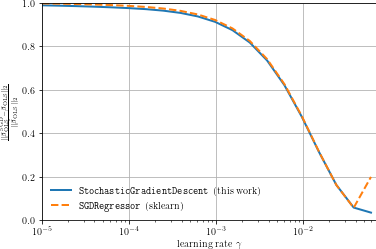

In [83]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_xlabel(r"learning rate  $\gamma$")
ax.set_ylabel(r"$\frac{||\hat{\beta}^\mathrm{SGD}_\mathrm{OLS} - \hat{\beta}_\mathrm{OLS}||_2}{||\hat{\beta}_\mathrm{OLS}||_2}$")
ax.plot(lrs, error_ridge_to_analytical, label=r"\texttt{StochasticGradientDescent} (this work)")
ax.plot(lrs, sk_error_ridge_to_analytical, ls="dashed", label=r"\texttt{SGDRegressor} (sklearn)")
ax.legend(*ax.get_legend_handles_labels())
ax.set_xlim([1e-5,0.07])
ax.set_ylim([0,1])
plt.show()

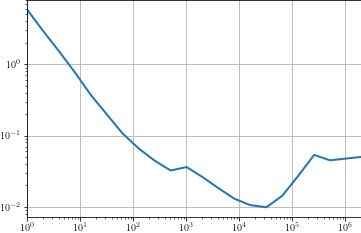

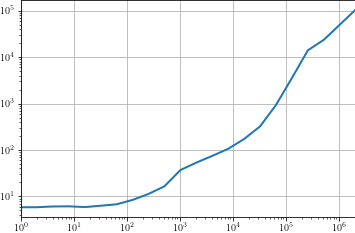

In [80]:
import timeit

task_general = '''
gradient_loss(X,z,p)
'''

N = 2**21
batchsizes= np.power(2,np.arange(22))
time_until_full_epoch = []

for b in batchsizes:
    setup = f'''
import numpy as np
X = np.random.rand({b},14)
z = np.random.rand({b})
p = p = np.random.rand(14)

def gradient_loss(X, y, p):
    return X.T @ (X @ p - y)
'''
    iterations_until_full_epoch = N//b
    time_until_full_epoch.append(timeit.timeit(task_general, setup=setup, number=iterations_until_full_epoch))
    
plt.loglog(batchsizes, time_until_full_epoch)
plt.show()
plt.loglog(batchsizes, batchsizes*time_until_full_epoch)
plt.show()

## Profiling the mess we created

In [51]:
from line_profiler import LineProfiler

minibatches = N
max_epochs = 100
tol=None
seed=42
lr = 1e-5
profile=True

ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=Constant(eta0=lr),
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

if profile:
    lp = LineProfiler()
    lp.add_function(OrdinaryLeastSquare.gradient_loss)
    lp.add_function(StochasticGradientDescent.minimize)
    lp.add_function(OrdinaryLeastSquare.fit)
    lp_wrapper=lp(ols_sgd.fit)
    lp_wrapper(X,z)
    lp.print_stats()

Timer unit: 1e-06 s

Total time: 1.56578 s
File: /Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/linear_model.py
Function: gradient_loss at line 60

Line #      Hits         Time  Per Hit   % Time  Line Contents
    60                                               def gradient_loss(self, X, y, p):
    61    204800     555739.0      2.7     35.5          y_pred = X @ p
    62    204800    1010040.0      4.9     64.5          return 2 * X.T @ (y_pred - y)

Total time: 7.03604 s
File: /Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/linear_model.py
Function: fit at line 64

Line #      Hits         Time  Per Hit   % Time  Line Contents
    64                                               def fit(self, X, y):
    65                                           
    66         1        245.0    245.0      0.0          X, X_mean, y, y_mean = self._center_data(X, y)
    67                                           
